<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/LC_identification_3_16_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. PROBLEM DEFINITION

**Background**

“A logistics cluster (LC) is defined as the geographical concentration of firms providing logistics services, such as transportation carriers, warehousing providers, third-party logistics (3PL-s), and forwarders, as well as some other enterprises that are mainly in the logistics business, including logistics enterprises to provide services to various industries” (Rivera et al., 2014, p. 223).  

Several relevant scholars in the field of logistics claim that clustering logistic activity has a positive impact on the efficiency of the economic activity, reduction of costs, and increase of collaboration among the firms that belong to the cluster (Rivera et al., 2014; Rivera, Gligor, et al., 2016; Rivera, Sheffi, et al., 2016; Sheffi, 2013, 2012). Although some of these authors mention that some of these benefits require some trade-offs (Rivera, Gligor, et al., 2016), these trade-offs are not further explored, resulting in an incomplete understanding of the socio-economic effects of the agglomeration of logistics activity. This becomes more problematic given that governments around the world seem to be embracing the idea of logistics clusters being some sort of panacea for economic development based on supply chain management improvements (Baranowski et al., 2015; Baydar et al., 2019; Chung, 2016), even though empirical studies that assess the role of government spending on the formation of logistics clusters are lacking (Liu et al., 2022). In other words, the field still lacks methodological and theoretical development, resulting in an incomplete understanding of the mechanisms of logistical clustering and their socio-economic effects.

**Problem**

There is not a current database of logistics clusters in the US. However, Rivera et al (2014) designed a method to test logistical agglomeration in US counties using NAICS codes and [CBP](https://www.census.gov/programs-surveys/cbp.html) information. Before conducting analyis on the effects of Logistics Clusters on society and the role of governments in their formation it is necessary to have an accurate picture of all logistics clusters in the US. For this purpose, I will extend Reviera's et al (2014) methodology to all the CBP years in which NAICS codes are used and use this database for future analyses.

#2. DATA COLLECTION

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import time

# -- this line is to make pandas future-proof, Copy-on-Write will become the default in pandas 3.0.
pd.options.mode.copy_on_write = True

# -- Set the data path
dpath = "/content/drive/MyDrive/Disertation/"

In [ ]:
# -- NAICS of interest according to Rivera et al.
naics_of_interest = [ "481112", "481212", "481219", "483111", "483113",
                      "483211", "484110", "484121", "484122", "484220",
                      "484230", "488119", "488190", "488210", "488310",
                      "488320", "488330", "488390", "488410", "488490",
                      "488510", "488991", "488999", "492110", "492210",
                      "493110", "493190"]
t0 = time.time()
for year in range(1998, 2022):
  xx = str(year)[2:]
  fname = dpath + "CBP_data/cbp" + xx + "co/cbp" + xx + "co.txt"
  temp = pd.read_csv(fname)
  if year == 2015:
    temp.columns = temp.columns.str.lower()
  # -- add a year column
  temp["year"] = year
  # -- add a GEOID
  temp["GEOID"] = temp.fipstate.astype(str).str.zfill(2) + temp.fipscty.astype(str).str.zfill(3)
  # -- create a global variable and save a dataframe into it
  globals()["cbp" + xx] = temp[temp["naics"].isin(naics_of_interest)]
  # -- create a global variable and save the total employment for each county
  globals()["cbp" + xx + "tot"] = temp[temp["naics"] == "------"]
  # -- delete to save RAM
  del temp
t1 = time.time()
print("Execution Time: ", (t1 - t0)/60, " mins")


Execution Time:  3.551813844839732  mins


#3. DATA PREPARATION

In [ ]:
# The CBP record layouts are different accross years.
cols_98_16 = ['fipstate', 'fipscty', 'naics', 'empflag', 'emp', 'ap', 'est',
              'n1_4', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
              'n500_999', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4',
              'year', 'GEOID']

cols_17    = ['fipstate', 'fipscty', 'naics', 'empflag', 'emp', 'ap', 'est',
              'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
              'n500_999', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4',
              'year', 'GEOID']

cols_18_21 = ['fipstate', 'fipscty', 'naics', 'emp_nf',  'emp', 'ap', 'est',
              'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
              'n500_999', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4',
              'year', 'GEOID']

t0 = time.time()
for year in range(1998, 2017):
  xx = str(year)[2:]
  globals()["cbp" + xx] = globals()["cbp" + xx][cols_98_16]
  globals()["cbp" + xx + "tot"] = globals()["cbp" + xx + "tot"][cols_98_16]

cbp17 = cbp17[cols_17]
cbp17.columns = cbp98.columns
cbp17tot = cbp17tot[cols_17]
cbp17tot.columns = cbp98.columns

#####  NOTE: CBP17 has object-type columns for the employment by establishment size.
# from 2017-2021 there are values that have N instead of 0 for emp by est size
cbp17[cbp17.columns[7:19]] = cbp17[cbp17.columns[7:19]].replace("N", 0).astype(int)
cbp17tot[cbp17tot.columns[7:19]] = cbp17tot[cbp17tot.columns[7:19]].replace("N", 0).astype(int)

for year in range(2018, 2022):
  xx = str(year)[2:]
  globals()["cbp" + xx] = globals()["cbp" + xx][cols_18_21]
  globals()["cbp" + xx][globals()["cbp" + xx].columns[7:19]] = globals()["cbp" + xx][globals()["cbp" + xx].columns[7:19]].replace("N", 0).astype(int)
  globals()["cbp" + xx].columns = cbp98.columns
  globals()["cbp" + xx + "tot"] = globals()["cbp" + xx + "tot"][cols_18_21]
  globals()["cbp" + xx + "tot"][globals()["cbp" + xx + "tot"].columns[7:19]] = globals()["cbp" + xx + "tot"][globals()["cbp" + xx + "tot"].columns[7:19]].replace("N", 0).astype(int)
  globals()["cbp" + xx + "tot"].columns = cbp98.columns


# -- Between 1998 and 2017, there was a suppression flag (empflag) that affects
#    the employment. Instead of using employment as it is, I will adjust it
#    based on the middle point of the employment by establishment size.



# -- create an unified dataframe for all years (1998-2017)
frames = [cbp98, cbp99, cbp00, cbp01, cbp02, cbp03, cbp04, cbp05, cbp06, cbp07,
          cbp08, cbp09, cbp10, cbp11, cbp12, cbp13, cbp14, cbp15, cbp16, cbp17,
          cbp18, cbp19, cbp20, cbp21]

cbp = pd.concat(frames).reset_index().drop(columns="index")
# -- lambda funditon to estimate employment if the employment is flagged
t0 = time.time()
cbp['emp_adj'] = cbp.apply(lambda row: row["emp"]
                           if pd.isna(row['empflag'])
                           else row['n1_4']*3 + row['n5_9']*7 +
                                row['n10_19']*15 + row['n20_49']*35 +
                                row['n50_99']*75 + row['n100_249']*175 +
                                row['n250_499']*375 + row['n500_999']*750 +
                                row['n1000_1']*1250 + row['n1000_2']*2000 +
                                row['n1000_3']*3760 + row['n1000_4']*5000, axis=1)
cbp = cbp.drop(columns=['n1_4', 'n5_9', 'n10_19', 'n20_49', 'n50_99',
                        'n100_249', 'n250_499', 'n500_999', 'n1000_1',
                        'n1000_2', 'n1000_3', 'n1000_4'])
cbp["emp_adj"] = cbp.apply(lambda row: row["emp"] if (row["year"]==2018)|(row["year"]==2019)|(row["year"]==2020)|(row["year"]==2021) else row["emp_adj"], axis=1)
# -- repeat for total employment
frames_tot = [cbp98tot, cbp99tot, cbp00tot, cbp01tot, cbp02tot, cbp03tot,
              cbp04tot, cbp05tot, cbp06tot, cbp07tot, cbp08tot, cbp09tot,
              cbp10tot, cbp11tot, cbp12tot, cbp13tot, cbp14tot, cbp15tot,
              cbp16tot, cbp17tot, cbp18tot, cbp19tot, cbp20tot, cbp21tot]

cbp_tot = pd.concat(frames_tot).reset_index().drop(columns="index")
# -- lambda funditon to estimate employment if the employment is flagged

cbp_tot['emp_adj'] = cbp_tot.apply(lambda row: row["emp"]
                           if pd.isna(row['empflag'])
                           else row['n1_4']*3 + row['n5_9']*7 +
                                row['n10_19']*15 + row['n20_49']*35 +
                                row['n50_99']*75 + row['n100_249']*175 +
                                row['n250_499']*375 + row['n500_999']*750 +
                                row['n1000_1']*1250 + row['n1000_2']*2000 +
                                row['n1000_3']*3760 + row['n1000_4']*5000, axis=1)

cbp_tot = cbp_tot.drop(columns=['n1_4', 'n5_9', 'n10_19', 'n20_49', 'n50_99',
                                'n100_249', 'n250_499', 'n500_999', 'n1000_1',
                                'n1000_2', 'n1000_3', 'n1000_4'])
cbp_tot["emp_adj"] = cbp_tot.apply(lambda row: row["emp"] if (row["year"]==2018)|(row["year"]==2019)|(row["year"]==2020)|(row["year"]==2021) else row["emp_adj"], axis=1)


# this cbp is from 1998-2021
cbp = cbp.groupby(["GEOID", "year", "fipstate", "fipscty"]).sum(numeric_only=True).reset_index()
cbp_tot = cbp_tot.groupby(["GEOID", "year", "fipstate", "fipscty"]).sum(numeric_only=True).reset_index()
# -- save the cvs to use it later
cbp.to_csv(dpath + "/cbp.csv", index = False)
cbp_tot.to_csv(dpath + "/cbp_tot.csv", index = False)
t1 = time.time()
print("Execution Time: ", (t1-t0)/60, " mins")

Execution Time:  0.5479361534118652  mins


In [22]:
# Run this line to get access to the most current version of the CBP
cbp_temp = pd.read_csv(dpath + "/cbp.csv")
cbp_temp["GEOID"] = cbp_temp["GEOID"].astype(str).apply(lambda x: x.zfill(5))
cbp = cbp_temp
cbp_temp = pd.read_csv(dpath + "/cbp_tot.csv")
cbp_temp["GEOID"] = cbp_temp["GEOID"].astype(str).apply(lambda x: x.zfill(5))
cbp_tot = cbp_temp
del cbp_temp

In [24]:
# --Removing non-continental counties
print(len(cbp))
# -- remove Alaska
cbp = cbp[cbp["fipstate"] != 2]
print(len(cbp))
# -- remove Hawaii
cbp = cbp[cbp["fipstate"] != 15]
print(len(cbp))
# -- remove American Samoa
cbp = cbp[cbp["fipstate"] != 60]
print(len(cbp))
# -- remove Guam
cbp = cbp[cbp["fipstate"] != 66]
print(len(cbp))
# -- remove Northern Marianas
cbp = cbp[cbp["fipstate"] != 69]
print(len(cbp))
# -- remove Puerto Rico
cbp = cbp[cbp["fipstate"] != 72]
print(len(cbp))
# -- remove Virgin Islands
cbp = cbp[cbp["fipstate"] != 78]
print(len(cbp))

72146
71549
71447
71447
71447
71447
71447
71447


In [25]:
# Rename columns from the total employment dataframe to merge it later
cbp_tot = cbp_tot.rename(columns={"emp":"tot_emp",	"ap":"tot_ap",	"est":"tot_est",	"emp_adj": "tot_emp_adj"})
# Eliminate columns that won't be required
cbp_tot = cbp_tot.drop(columns=["fipstate", "fipscty"])
# Merge dataframes
print("CBP: ", len(cbp))
print("CBP total: ", len(cbp_tot))
cbp = cbp.merge(cbp_tot, left_on=("GEOID","year"), right_on=("GEOID", "year"), how= "outer").fillna(0)
print("Merged dataset: ", len(cbp))

# Get yearly totals
cbp_tot_year = cbp.groupby("year").sum(numeric_only = True)[["emp_adj", "tot_emp_adj"]]
# Rename columns before merging
cbp_tot_year = cbp_tot_year.rename(columns={"emp_adj":"country_sector",	"tot_emp_adj":"country_total"}).reset_index()
# Merge dataframes
cbp = cbp.merge(cbp_tot_year, left_on="year", right_on="year")

# Total establishments of logistics and warehousing in the whole country per year
cbp = cbp.merge(cbp.groupby("year").sum(numeric_only=True)[["est"]].reset_index().rename(columns={"est": "est_country"}), left_on="year", right_on="year")

# -- Create variables
# Logistics Establishments' Participation
cbp["LEP"] = cbp.est / cbp.est_country

# Location Quotient
cbp["LQ"] = (cbp.emp_adj/cbp.country_sector) / (cbp.tot_emp_adj/cbp.country_total)

# Horizontal Cluster Location Quotient
cbp["emp_expd"] = cbp.country_sector*cbp.tot_emp_adj/cbp.country_total
cbp["HCLQ"] = cbp.emp_adj - cbp.emp_expd

CBP:  71447
CBP total:  76537
Merged dataset:  76537


#4. MACHINE LEARNING

In [26]:
geo = gpd.read_file("/content/drive/MyDrive/Disertation/countyshp/tl_2010_us_county00/tl_2010_us_county00.shp")
cols = ['CNTYIDFP00','NAME00','geometry']
geo = geo[cols]
cbp = geo.merge(cbp, right_on = "GEOID", left_on = 'CNTYIDFP00').drop(columns = 'CNTYIDFP00')

<Axes: >

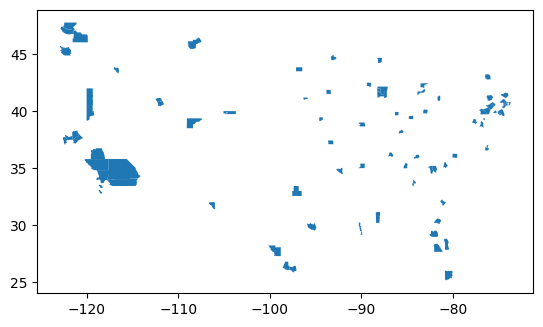

In [27]:
cbp[(cbp.LQ > 1)&(cbp.year == 2008)&(cbp.LEP>0.001)].plot()

In [28]:
len(cbp[(cbp.LEP>0.001)&(cbp.HCLQ>0)&(cbp.year==2008)])

90

In [ ]:
list()

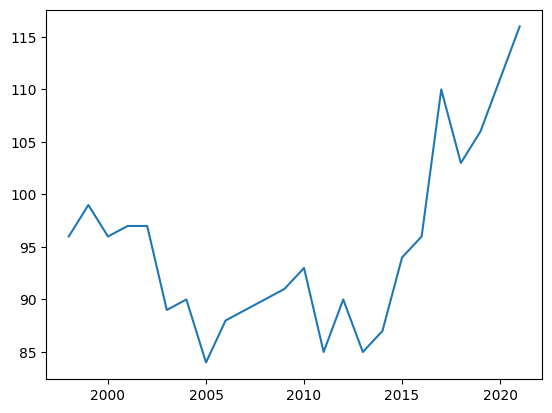

In [36]:
LC = []
for year in range(1998,2022):
  LC.append(len(cbp[(cbp.LEP>0.001)&(cbp.HCLQ>0)&(cbp.year==year)]))
plt.plot(list(range(1998,2022)), LC)

#5. PROBLEM SOLUTION